In [1]:
import numpy as np
import matplotlib.pyplot as plt

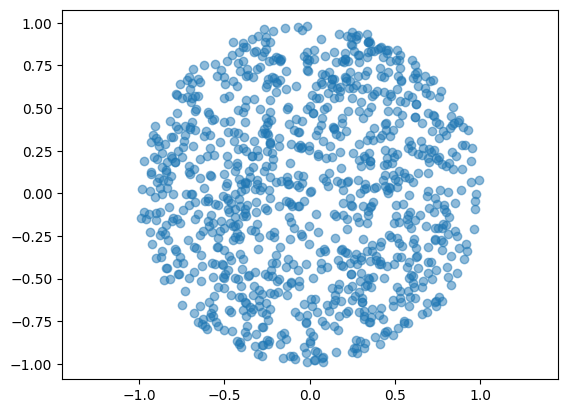

In [2]:
def sample_circle(n_points: int, radius: float = 1.0) -> np.ndarray:
    def generate_circle(n_points: int, radius: float = 1.0) -> np.ndarray:
        """Generate points uniformly distributed within a circle.
        
        Uses rejection sampling for efficiency.
        """
        # Generate points in a square and reject those outside circle
        points = (np.random.random((n_points, 2)) - 0.5) * 2 * radius
        mask = np.sum(points**2, axis=1) <= radius**2
        return points[mask]

# Draw points until we have 1000
    points = []
    while len(points) < n_points:
        new_points = generate_circle(n_points - len(points))
        points.extend(new_points)
    return np.array(points[:n_points])

points = sample_circle(1000)
plt.scatter(points[:, 0], points[:, 1], alpha=0.5)
plt.axis('equal')
plt.show()


In [3]:
points.shape

(1000, 2)

In [4]:
def gaussian_activation(center: np.ndarray, points: np.ndarray, sigma: float = 0.1) -> np.ndarray:
    """Calculate Gaussian activation values for all points relative to a center.
    
    Args:
        center: Center point coordinates of shape (2,)
        points: Array of points to evaluate, shape (N, 2)
        sigma: Width parameter of the Gaussian
        
    Returns:
        Array of activation values for each point, shape (N,)
    """
    distances = np.sum((points - center)**2, axis=1)
    return np.exp(-distances / (2 * sigma**2))

# Example usage


def plot_activations(activations: np.ndarray, points: np.ndarray, center: np.ndarray):
    plt.figure(figsize=(10, 4))

    # Plot points colored by activation
    plt.subplot(121)
    plt.scatter(points[:, 0], points[:, 1], c=activations, cmap='viridis')
    plt.colorbar(label='Activation')
    plt.plot(center[0], center[1], 'r*', markersize=15, label='Center')
    plt.axis('equal')
    plt.legend()

    # Plot activation surface
    xx, yy = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
    grid_points = np.column_stack((xx.ravel(), yy.ravel()))
    grid_activations = gaussian_activation(center, grid_points)
    plt.subplot(122)
    plt.contourf(xx, yy, grid_activations.reshape(100, 100), levels=20, cmap='viridis')
    plt.colorbar(label='Activation')
    plt.plot(center[0], center[1], 'r*', markersize=15, label='Center')
    plt.axis('equal')
    plt.legend()

    plt.tight_layout()
    plt.show()


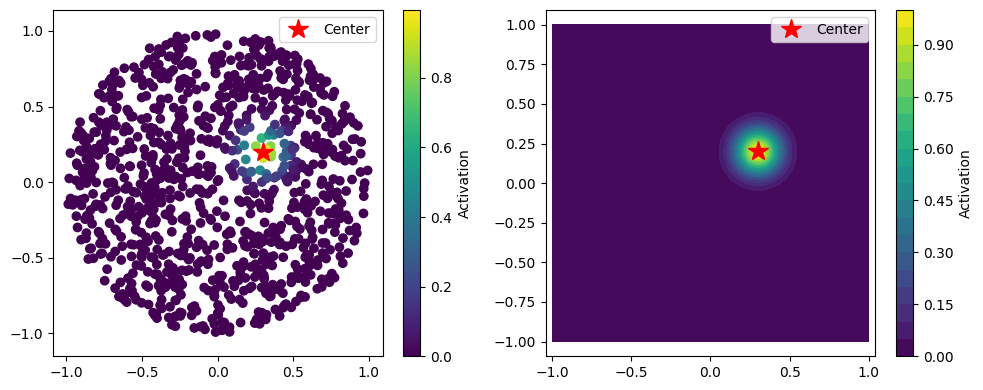

In [5]:
center = np.array([0.3, 0.2])
activations = gaussian_activation(center, points)

plot_activations(activations=activations, points=points, center=center)

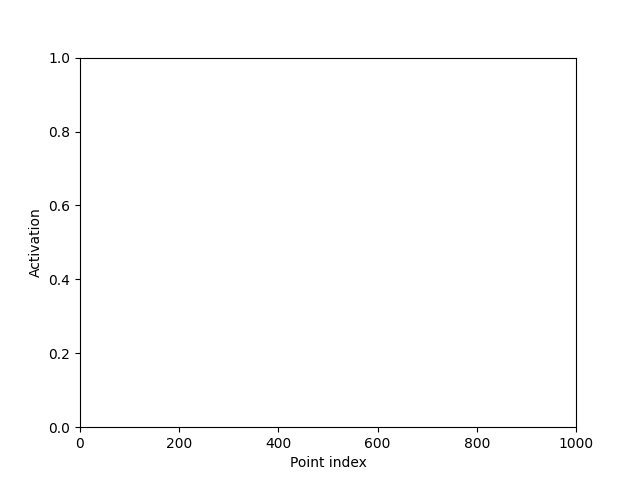

In [12]:
%matplotlib ipympl

from matplotlib.animation import FuncAnimation

# Create a line of centers
t = np.linspace(0, 1, 50)
centers = np.column_stack((0.3 + 0.4*t, 0.2 + 0.3*t))

fig, ax = plt.subplots()
line, = ax.plot([], [])
ax.set_xlim(0, len(points))
ax.set_ylim(0, 1)
ax.set_xlabel('Point index')
ax.set_ylabel('Activation')

def update(frame):
    center = centers[frame]
    activations = gaussian_activation(center, points)
    line.set_data(np.arange(len(activations)), activations)
    return line,

anim = FuncAnimation(fig, update, frames=len(centers), interval=50, blit=True)
plt.show()

In [6]:
n_features_vectors = 10000
features_vectors = []
centers = sample_circle(n_features_vectors)
for center in centers:
    features_vectors.append(gaussian_activation(center, points))

features_vectors = np.array(features_vectors)
features_vectors.shape


(10000, 1000)

In [7]:
from sklearn.manifold import TSNE
tsne_embedding = TSNE(n_components=2).fit_transform(features_vectors)
tsne_embedding.shape


(10000, 2)

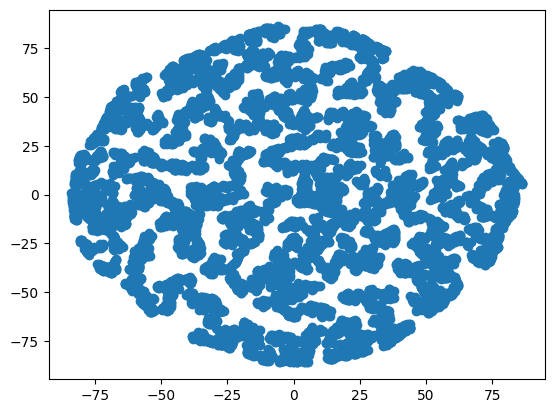

In [8]:
plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1])
plt.show()


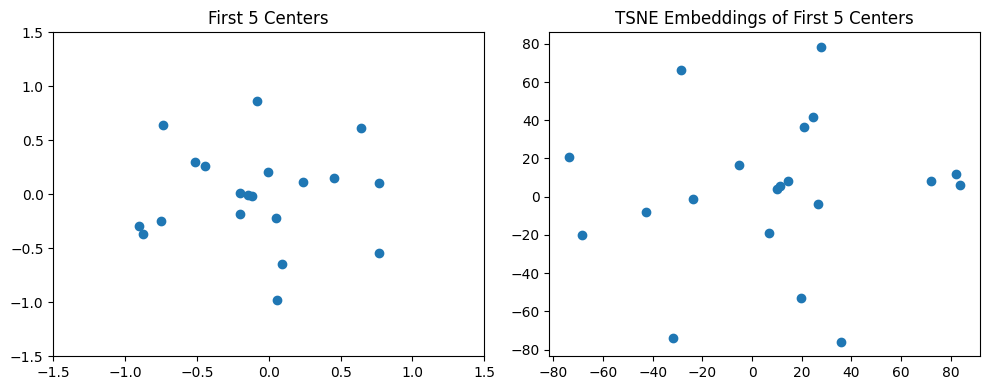

In [10]:
# Display first 5 centers and their TSNE embeddings
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot first 5 centers
ax1.scatter(centers[:20, 0], centers[:20, 1])
ax1.set_title('First 5 Centers')
ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-1.5, 1.5)

# Plot corresponding TSNE embeddings
ax2.scatter(tsne_embedding[:20, 0], tsne_embedding[:20, 1])
ax2.set_title('TSNE Embeddings of First 5 Centers')

plt.tight_layout()
plt.show()


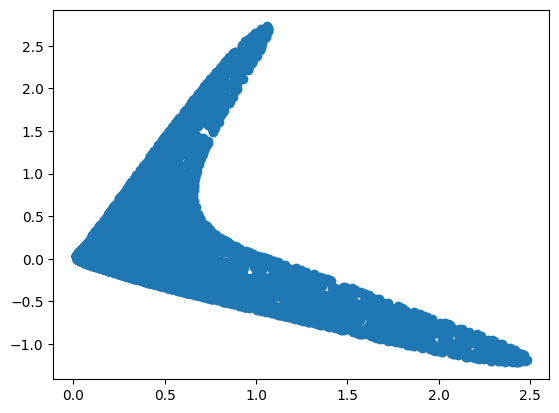

In [11]:
from umap import UMAP
umap_embedding = UMAP(n_components=2).fit_transform(features_vectors)
umap_embedding.shape

plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1])
plt.show()
